__I'm going to be working with a dataset regarding DAW usage.__

- A DAW (Digital Audio Workstation) is a software used for recording, editing, mixing, and otherwise producing
music or other audio (foley, sfx, voiceover, etc...).

- I couldn't find many datasets on this topic, and of what I could find, almost all came from one company that
locked them behind a paywall. The exception is this dataset out of Universitá Degli Studi di Milano:
Ludovico, Luca Andrea; Avanzini, Federico; Presti, Giorgio, 2025, "Data for: DAW Usage Survey (2023)",
https://doi.org/10.13130/RD_UNIMI/YNQHKI, UNIMI Dataverse, V2 

- For more information on data collection methods, the associated readme has been included in this notebook.

The file is a json rather than a csv, so the loading process is a bit more awkward

In [1]:
import pandas as pd
import numpy as np
import json
import seaborn as sb
import matplotlib.pyplot as plt

In [2]:
raw_daw_df = pd.DataFrame()
with open('daw_survey.json') as file:
    json_data = json.load(file)
    raw_daw_df = pd.json_normalize(json_data)
raw_daw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 615 entries, 0 to 614
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UseCases                 615 non-null    object 
 1   PersonalData.Gender      614 non-null    object 
 2   PersonalData.Age         614 non-null    object 
 3   PersonalData.Country     614 non-null    object 
 4   PersonalData.Instrument  614 non-null    object 
 5   PersonalData.Level       614 non-null    object 
 6   PersonalData.Company     614 non-null    object 
 7   PersonalData.Training    614 non-null    object 
 8   PersonalData.DAW         614 non-null    object 
 9   PersonalData.Source      614 non-null    object 
 10  PersonalData             0 non-null      float64
dtypes: float64(1), object(10)
memory usage: 53.0+ KB


In [3]:
raw_daw_df.head()

,UseCases,PersonalData.Gender,PersonalData.Age,PersonalData.Country,PersonalData.Instrument,PersonalData.Level,PersonalData.Company,PersonalData.Training,PersonalData.DAW,PersonalData.Source,PersonalData
0,"[{'id': 0, 'OS': 'Windows', 'DAW': 'FL studio'...",Male,25-29,Italy,[Electronic self-taught],"[Hobby, Job]",No,Yes,FL studio,tgum,NaN
1,"[{'id': 0, 'OS': 'Windows', 'DAW': 'FL studio'...",Male,18-24,Italy,"[(electro)Acoustic with teacher, (electro)Acou...","[Hobby, Job]",No,No,FL studio,tgim,NaN
2,"[{'id': 0, 'OS': 'Windows', 'DAW': 'FL studio'...",Male,18-24,Italy,[(electro)Acoustic with teacher],[Hobby],No,No,FL studio,tgum,NaN
3,"[{'id': 0, 'OS': 'Mac', 'DAW': 'Nuendo', 'Star...",Male,30-34,Netherlands,"[(electro)Acoustic self-taught, Electronic sel...",[Job],Owner,Yes,Nuendo,rtaue,NaN
4,"[{'id': 0, 'OS': 'Windows', 'DAW': 'Reaper', '...",Male,25-29,Israel,"[(electro)Acoustic with teacher, (electro)Acou...","[Hobby, Job]",Employee,Yes,Reaper,rtaue,NaN


__Looks like the UseCases section is still nested, let's fix that.__

In [4]:
print(type(raw_daw_df["UseCases"][0]), "of", type(raw_daw_df["UseCases"][0][0]))

<class 'list'> of <class 'dict'>


We see that the use cases object is a list split up into a dictionary with each dict containing info for each DAW the user entered.
Below we can see that some of the elements in the dict are themselves lists, but that each one has the same set of keys.

In [5]:
use_cases_0 = raw_daw_df["UseCases"][0]
for x in use_cases_0:
    print(x,"\n")

{'id': 0, 'OS': 'Windows', 'DAW': 'FL studio', 'Start': '2012', 'End': '2023', 'Task': ['Draft', 'Tracking', 'Editing', 'Sequencing and Programming', 'Mixing', 'Mastering', 'Post-production', 'Scientific research or measurements'], 'Context': ['Music (Electronic)', 'Sampling', 'Sound design', 'Soundtrack', 'Speech recording'], 'Level': 'Semi-professional'} 

{'id': 1, 'OS': 'Windows', 'DAW': 'Audacity', 'Start': '2012', 'End': '2023', 'Task': ['Editing', 'Post-production', 'Scientific research or measurements'], 'Context': ['Music (Electronic)', 'Sampling', 'Speech recording'], 'Level': 'Semi-professional'} 

{'id': 2, 'OS': 'Windows', 'DAW': 'Tracktor', 'Start': '2012', 'End': '2016', 'Task': ['Live performance'], 'Context': ['Music (Electronic)', 'Sampling'], 'Level': 'Semi-professional'} 

{'id': 3, 'OS': 'Windows', 'DAW': 'Pro tools', 'Start': '2018', 'End': '2019', 'Task': ['Editing', 'Mixing'], 'Context': ['Music (Electronic)', 'Speech recording'], 'Level': 'Semi-professional'} 


__What's the best way to handle this? We could:__ 

    - Turn each of these dicts into a dataframe and add each to the id row it came from under a new column. This would require creating a column for every DAW represented,
    because having a column for UseCase.id would give a mix of DAWs for each column, which is less useful than having the DAWs together. This feels slightly redundant given
    that we have a DAW column under PersonalData, but that is restricted to one DAW per entrant, and doesn't include the depth of UseCases. The readme states that the 
    "PersonalData.DAW" data is "primary DAW they use," which could have slightly different interpretations between users.
    
    - Completely unpack these lists into individual columns. This would provide the most control in theory, but would be a nightmare to work with. Bad.
    
    - Rather than merging this data into the PersonalData list, we could handle it completely seperately. This lets us clearly see what the common uses are for each DAW
    in question, but loses out on the information connecting users to their DAWs, i.e. what age are/were most users of a given DAW? The UseCase dict contains start and end
    dates for their use, but does NOT include the age of the user. Other connecting data exists and would be lost, such as connections between instrument and DAW, level of
    training and DAW, etc...

I think the right combination of options 1 and 3 would be to create a DataFrame with columns for each DAW containing their corresponding dicts (discarding unneeded values 
such as the name of the DAW itself (already in the header) and ID) and then renaming the "PersonalData.DAW" column to "Primary DAW". The DataFrame can be either combined
with the original, or kept seperate as an associated DataFrame, where each row corresponds to the same user as the row with the same index in the original DataFrame.

The first step of this process is to initialize a DataFrame where all DAWs are marked as Unused

In [6]:
# First create a template for a blank row, representing the DAWs used by one user.
# Do this by first getting the names of all DAWs represented by iterating through
# the raw DataFrame
daw_names = set()
for i in raw_daw_df["UseCases"]:
    for j in i:
        daw_names.add(j["DAW"])

use_cases_by_daw_df = pd.DataFrame(columns=list(daw_names), index=np.arange(len(raw_daw_df)), data=None) 

use_cases_by_daw_df.head()

,,Acid pro,Biab,Ardour,Reason,Audacity,Other,Pyramix,Digital performer,Cubase,...,Nuendo,Mainstage,Cakewalk,Soundbooth,Goldwave,Pro tools,Non daw studio,Mixbus,Samplitude,Renoise
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now let's populate this new DataFrame with UseCases

In [7]:
# Once again iterate through all rows' UseCases column
current_row = 0
for i in raw_daw_df["UseCases"]:

    # Iterate through all items in the list
    for j in i:

        # Get the DAW we're looking at
        current_daw = j["DAW"]

        # Strip id and DAW from each dict, as id is not useful and
        # DAW is redundant since it is already the column label
        # Do this on a duplicate so as not to modify the raw data
        use_case = j
        use_case.pop('id')
        use_case.pop('DAW')

        # Add the element to the new DataFrame
        use_cases_by_daw_df.at[current_row, current_daw] = use_case

    current_row = current_row + 1

use_cases_by_daw_df.head()

,,Acid pro,Biab,Ardour,Reason,Audacity,Other,Pyramix,Digital performer,Cubase,...,Nuendo,Mainstage,Cakewalk,Soundbooth,Goldwave,Pro tools,Non daw studio,Mixbus,Samplitude,Renoise
0,NaN,NaN,NaN,NaN,NaN,"{'OS': 'Windows', 'Start': '2012', 'End': '202...",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"{'OS': 'Windows', 'Start': '2018', 'End': '201...",NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"{'OS': 'Mac', 'Start': '2014', 'End': '2023', ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Checking out the info for this shows us the number of uses reported for each DAW.

In [8]:
use_cases_by_daw_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 615 entries, 0 to 614
Data columns (total 42 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0                       14 non-null     object
 1   Acid pro            7 non-null      object
 2   Biab                1 non-null      object
 3   Ardour              18 non-null     object
 4   Reason              20 non-null     object
 5   Audacity            51 non-null     object
 6   Other               26 non-null     object
 7   Pyramix             2 non-null      object
 8   Digital performer   10 non-null     object
 9   Cubase              95 non-null     object
 10  Soundforge          8 non-null      object
 11  FL studio           68 non-null     object
 12  SpectraLayers       1 non-null      object
 13  Adobe audition      29 non-null     object
 14  WaveLab             11 non-null     object
 15  Bitwig studio       9 non-null      object
 16  Acoustica Mixcraft  4 non-null 

There appears to be an unlabeled column 0 with 14 non-null entries, let's check that out:

In [9]:
for x in use_cases_by_daw_df[""]:
    if str(x) != "nan":
        print(x)

{'OS': 'Windows', 'Start': '2012', 'End': '2023', 'Task': ['Draft', 'Tracking', 'Editing', 'Sequencing and Programming', 'Mixing', 'Mastering', 'Live sound engineering'], 'Context': ['Music (Electroacoustic)', 'Music (Electronic)'], 'Level': 'Amateur'}
{'OS': 'Windows', 'Start': '2011', 'End': '2023', 'Task': ['Draft', 'Tracking', 'Editing', 'Mixing', 'Post-production', 'Restoration'], 'Context': ['Music (Acoustic)', 'Music (Electroacoustic)', 'Sound design', 'Foley', 'Soundtrack', 'Speech recording'], 'Level': 'Professional'}
{'OS': 'Mac', 'Start': '2011', 'End': '2023', 'Task': ['Tracking', 'Editing', 'Mixing', 'Post-production', 'Restoration', 'Other'], 'Context': ['Music (Electronic)', 'Sampling', 'Sound art', 'Sound design', 'Foley', 'Soundtrack', 'Speech recording', 'Other'], 'Level': 'Semi-professional'}
{'OS': '', 'Start': '2010', 'End': '2023', 'Task': [], 'Context': [], 'Level': 'Professional'}
{'OS': 'Mac', 'Start': '2021', 'End': '2023', 'Task': ['Draft', 'Mixing', 'Masteri

It appears that users put the use cases they use DAWs for without specifying which DAW. For now, I'll simply label this column "Unspecified"

In [10]:
use_cases_by_daw_df.rename(columns={"": "Unspecified"}, inplace=True)
use_cases_by_daw_df.head()

,Unspecified,Acid pro,Biab,Ardour,Reason,Audacity,Other,Pyramix,Digital performer,Cubase,...,Nuendo,Mainstage,Cakewalk,Soundbooth,Goldwave,Pro tools,Non daw studio,Mixbus,Samplitude,Renoise
0,NaN,NaN,NaN,NaN,NaN,"{'OS': 'Windows', 'Start': '2012', 'End': '202...",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"{'OS': 'Windows', 'Start': '2018', 'End': '201...",NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"{'OS': 'Mac', 'Start': '2014', 'End': '2023', ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


While working on column headers, let's clean up both these use case ones and the PersonalData ones

In [11]:
use_cases_by_daw_df.columns.str.strip().str.title()

Index(['Unspecified', 'Acid Pro', 'Biab', 'Ardour', 'Reason', 'Audacity',
       'Other', 'Pyramix', 'Digital Performer', 'Cubase', 'Soundforge',
       'Fl Studio', 'Spectralayers', 'Adobe Audition', 'Wavelab',
       'Bitwig Studio', 'Acoustica Mixcraft', 'Waveform', 'Serato Studio',
       'Logic', 'Studio One', 'Mulab', 'Garageband', 'Soundtrap',
       'N-Track Studio', 'Music Maker', 'Tracktor', 'Audiotool',
       'Ableton Live', 'Sonic Visualizer', 'Rx', 'Reaper', 'Nuendo',
       'Mainstage', 'Cakewalk', 'Soundbooth', 'Goldwave', 'Pro Tools',
       'Non Daw Studio', 'Mixbus', 'Samplitude', 'Renoise'],
      dtype='object')

In [12]:
# Removing the UseCases column as we've handled that now
personal_data_df = raw_daw_df.drop(columns=['UseCases'])

Before cleaning the PersonalData headers, there's a suspicious column only labeled "PersonalData" let's get some more info.

In [13]:
personal_data_df['PersonalData'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 615 entries, 0 to 614
Series name: PersonalData
Non-Null Count  Dtype  
--------------  -----  
0 non-null      float64
dtypes: float64(1)
memory usage: 4.9 KB


Looks like it has no non-null values, so let's simply drop it and then clean the names

In [14]:
# Remove unneeded column
if "PersonalData" in personal_data_df.keys():
    personal_data_df.drop(columns='PersonalData', inplace=True)

# Remove the PersonalData prefix from column names
new_names = dict()
for s in personal_data_df.columns:
    new_names[s] = s.strip().split(".")[1]

personal_data_df.rename(columns=new_names, inplace=True)

personal_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 615 entries, 0 to 614
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Gender      614 non-null    object
 1   Age         614 non-null    object
 2   Country     614 non-null    object
 3   Instrument  614 non-null    object
 4   Level       614 non-null    object
 5   Company     614 non-null    object
 6   Training    614 non-null    object
 7   DAW         614 non-null    object
 8   Source      614 non-null    object
dtypes: object(9)
memory usage: 43.4+ KB


__So after this phase of data cleaning, here are our current DataFrames:__

In [15]:
personal_data_df.head(10)

,Gender,Age,Country,Instrument,Level,Company,Training,DAW,Source
0,Male,25-29,Italy,[Electronic self-taught],"[Hobby, Job]",No,Yes,FL studio,tgum
1,Male,18-24,Italy,"[(electro)Acoustic with teacher, (electro)Acou...","[Hobby, Job]",No,No,FL studio,tgim
2,Male,18-24,Italy,[(electro)Acoustic with teacher],[Hobby],No,No,FL studio,tgum
3,Male,30-34,Netherlands,"[(electro)Acoustic self-taught, Electronic sel...",[Job],Owner,Yes,Nuendo,rtaue
4,Male,25-29,Israel,"[(electro)Acoustic with teacher, (electro)Acou...","[Hobby, Job]",Employee,Yes,Reaper,rtaue
5,Male,35-39,Latvia,[Electronic self-taught],[Hobby],No,No,Reaper,rtaue
6,Male,18-24,Italy,[],[Hobby],No,No,FL studio,tgim
7,Male,40-49,Spain,"[(electro)Acoustic with teacher, (electro)Acou...",[Job],Owner,Yes,Nuendo,rtaue
8,Male,40-49,United Kingdom,"[(electro)Acoustic self-taught, Electronic sel...",[Hobby],No,No,Cubase,rtaue
9,Male,18-24,Italy,"[(electro)Acoustic with teacher, (electro)Acou...","[Hobby, Job]",No,No,FL studio,tgum_s


In [16]:
use_cases_by_daw_df.head(10)

,Unspecified,Acid pro,Biab,Ardour,Reason,Audacity,Other,Pyramix,Digital performer,Cubase,...,Nuendo,Mainstage,Cakewalk,Soundbooth,Goldwave,Pro tools,Non daw studio,Mixbus,Samplitude,Renoise
0,NaN,NaN,NaN,NaN,NaN,"{'OS': 'Windows', 'Start': '2012', 'End': '202...",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"{'OS': 'Windows', 'Start': '2018', 'End': '201...",NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"{'OS': 'Mac', 'Start': '2014', 'End': '2023', ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,"{'OS': 'Mac', 'Start': '2005', 'End': '2023', ...",NaN,NaN,NaN,NaN,NaN,...,"{'OS': 'Mac', 'Start': '2013', 'End': '2023', ...",NaN,NaN,NaN,NaN,"{'OS': 'Mac', 'Start': '2004', 'End': '2023', ...",NaN,NaN,NaN,NaN
8,"{'OS': 'Windows', 'Start': '2012', 'End': '202...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


__MORE DATA:__
    
    - As requested, I'll import some data on search popularity for various DAWs represented in this survey. We previously
    identified the usage popularity of each DAW, so I'll narrow the focus of the Google Trends results to look at only
    the DAWs with over 50 users, those being, in order of popularity:
        Ableton Live, Reaper, Pro Tools, Logic, Cubase, FL Studio, and Audacity
    
    - Search terms won't necessarily represent DAW interest for Reaper, Logic, Audacity, and possibly even Pro Tools, 
    whose names all have alternate meanings. However, Google Trends has a feature where I can specify that I mean
    the audio editing software, so this shouldn't be a huge issue.

    - What is an issue though, is that Google Trends limits me to 5 items in a comparison. Reaper is a comparatively
    new DAW, so results going back several years won't be as useful. I'll also exclude Audacity, as I expect that we'll 
    see its use cases are different from these other DAWs. If I see later that doesn't end up being the case I may have
    to reconsider its exclusion, but the software is just fundamentally different from the other big names, so I feel
    comfortable doing so for now.

In [17]:
search_trends_global_df = pd.read_csv('multiTimeline.csv')
search_trends_global_df.head()

,,,,,Category: Music & Audio
Month,Ableton Live: (Worldwide),Cubase: (Worldwide),FL Studio: (Worldwide),Pro Tools: (Worldwide),Logic Pro: (Worldwide)
2004-01,12,96,100,77,11
2004-02,14,88,87,79,9
2004-03,14,80,91,69,9
2004-04,12,80,86,72,8


In [18]:
search_trends_by_region_df = pd.read_csv('geoMap.csv')
search_trends_by_region_df.head()

,,,,,Category: Music & Audio
Country,Ableton Live: (1/1/04 - 10/24/25),Cubase: (1/1/04 - 10/24/25),FL Studio: (1/1/04 - 10/24/25),Pro Tools: (1/1/04 - 10/24/25),Logic Pro: (1/1/04 - 10/24/25)
Solomon Islands,NaN,NaN,NaN,NaN,NaN
Iceland,NaN,NaN,NaN,NaN,NaN
British Virgin Islands,NaN,NaN,NaN,NaN,NaN
Faroe Islands,NaN,NaN,NaN,NaN,NaN


In [19]:
search_trends_by_region_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 251 entries, ('Country', 'Ableton Live: (1/1/04 - 10/24/25)', 'Cubase: (1/1/04 - 10/24/25)', 'FL Studio: (1/1/04 - 10/24/25)', 'Pro Tools: (1/1/04 - 10/24/25)') to ('South Sudan', nan, nan, nan, nan)
Data columns (total 1 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Category: Music & Audio  59 non-null     object
dtypes: object(1)
memory usage: 17.7+ KB


It looks like only 59 regions have usable data, so I'll drop the ones that don't, and rename any remaining NaN values to show lack of interest.

In [20]:
search_trends_by_region_df.dropna(inplace=True)
search_trends_by_region_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 59 entries, ('Country', 'Ableton Live: (1/1/04 - 10/24/25)', 'Cubase: (1/1/04 - 10/24/25)', 'FL Studio: (1/1/04 - 10/24/25)', 'Pro Tools: (1/1/04 - 10/24/25)') to ('Iran', '5%', '13%', '79%', '2%')
Data columns (total 1 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Category: Music & Audio  59 non-null     object
dtypes: object(1)
memory usage: 15.0+ KB


In [21]:
search_trends_by_region_df.head()

,,,,,Category: Music & Audio
Country,Ableton Live: (1/1/04 - 10/24/25),Cubase: (1/1/04 - 10/24/25),FL Studio: (1/1/04 - 10/24/25),Pro Tools: (1/1/04 - 10/24/25),Logic Pro: (1/1/04 - 10/24/25)
Australia,35%,10%,24%,23%,8%
Switzerland,34%,17%,28%,12%,9%
Belgium,32%,13%,37%,12%,6%
Netherlands,26%,14%,44%,10%,6%


In [22]:
search_trends_by_region_df.isna()

,,,,,Category: Music & Audio
Country,Ableton Live: (1/1/04 - 10/24/25),Cubase: (1/1/04 - 10/24/25),FL Studio: (1/1/04 - 10/24/25),Pro Tools: (1/1/04 - 10/24/25),False
Australia,35%,10%,24%,23%,False
Switzerland,34%,17%,28%,12%,False
Belgium,32%,13%,37%,12%,False
Netherlands,26%,14%,44%,10%,False
Norway,22%,15%,39%,16%,False
Estonia,22%,11%,55%,8%,False
Ireland,35%,9%,25%,24%,False
Denmark,28%,13%,35%,15%,False
United Kingdom,31%,17%,23%,17%,False


No NaN values seem to remain, so I think I'm calling the data __successfully cleaned!__

**<h1> Exploratory Data Analysis </h1>**

This data provides many interesting comparisons we could depict between DAW choice and some user data. Since I'm to create three graphs, I'll begin by examining DAW vs. Age, Use Cases by DAW, and two analyses of time frames of each DAW: one with the Universitá Degli Studi di Milano dataset and one with the Google Trends dataset. 

 - DAW vs. Age is a nice simple way to start. It gives numerical data and can be easily graphed. It'll help warm me up for the more complicated scenarios.
 - Use Cases by DAW is going to be more interesting. It will take a good bit more manipulation, but I'm really curious how the results turn out.
 - Time frame of each DAW will be a good indicator of the overall trajectory of each DAW. It's easy to just take Google Trends at its word, but we can now compare that against the data from Universitá Degli Studi di Milano to see what holds better. I think it's also worth noting that actually using a DAW is far, far different from a Google search! Some searchers might have interest in the DAW but not use it, while for others it could indicate the learning curve or userbase of the software in question.

Let's start by creating a threshold for the significance of DAWs; we don't want to consider those with so few data points as to create the impression of significance where there isn't any.

In [23]:
use_cases_by_daw_df.count().sort_values(ascending=False)

Ableton Live          226
Reaper                157
Pro tools             122
Logic                 118
Cubase                 95
FL studio              68
Audacity               51
Adobe audition         29
Other                  26
RX                     24
Studio one             21
Reason                 20
Garageband             18
Ardour                 18
Unspecified            14
Cakewalk               13
WaveLab                11
Nuendo                 10
Sonic visualizer       10
Digital performer      10
Bitwig studio           9
Soundforge              8
Acid pro                7
Tracktor                5
Acoustica Mixcraft      4
Mixbus                  4
Samplitude              4
Soundtrap               3
Mainstage               3
Non daw studio          2
Mulab                   2
n-track studio          2
Serato studio           2
Waveform                2
Pyramix                 2
Audiotool               1
Music maker             1
Soundbooth              1
Goldwave    

A conservative threshold would be 50, which should definitely be enough data for each category, but I'm tempted to try a threshold of 15 to get more DAWs to compare. I'll try a run with each threshold in every case. 

That being said, we can now remove any DAWs with fewer than 15 users. I'm going to leave the "Other" column in place, because I'm curious if we see any trends in use cases that aren't represented by the DAWs listed on the survey.

**<h1> DAW vs. Age </h1>**

I'll represent this data using a boxplot, with the horizontal axis containing sections for each DAW, and the vertical axis representing the age of the respondant.

First, I need to convert the Age data into numeric data. I assume that all age ranges are either:
    - 5 characters: a 2-digit lower bound, a hyphen, and a 2-digit upper bound. I can create an average by using string manipulation and store this average in a new column.
    - The strings ">=60" or "<=18". I will just leave these as 60 and 18, respectively, as there does not appear to be a good way to average these numbers with some invented other bound.

After examining the data, there appears to be a single nan value present in personal_data_df (615 total entries, but every column has 614 non-nan entries).
I will remove that before proceeding. There is also no row 593, causing problems down the line, so I'm resetting the index numbers here.

In [24]:
personal_data_df = personal_data_df.dropna()
personal_data_df = personal_data_df.reset_index(drop=True)
personal_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Gender      614 non-null    object
 1   Age         614 non-null    object
 2   Country     614 non-null    object
 3   Instrument  614 non-null    object
 4   Level       614 non-null    object
 5   Company     614 non-null    object
 6   Training    614 non-null    object
 7   DAW         614 non-null    object
 8   Source      614 non-null    object
dtypes: object(9)
memory usage: 43.3+ KB


In [25]:
average_age = pd.Series(dtype=float, data=np.full(len(personal_data_df["Age"]), fill_value = 0))
for i, a in enumerate(personal_data_df["Age"]):
    if str(a)[0] == ">":
        average_age[i] = int(60)
    elif str(a)[0] == "<":
        average_age[i] = int(18)
    else:
        average_age[i] = int((int(str(a)[0:2]) + int(str(a)[3:5])) / 2)

personal_data_df.insert(column="AdjustedAge", value=average_age, loc=3)

personal_data_df["AdjustedAge"].describe()

count    614.000000
mean      37.385993
std       12.869626
min       18.000000
25%       27.000000
50%       37.000000
75%       44.000000
max       60.000000
Name: AdjustedAge, dtype: float64

<h3> Mask the use cases DataFrame into two new Dataframes, one for each threshold </h3>

In [26]:
threshold_fifty_uses_mask = list(use_cases_by_daw_df.count() < 50)
threshold_fifteen_uses_mask = list(use_cases_by_daw_df.count() < 15)

over_fifty_uses_df = use_cases_by_daw_df.copy()
over_fifteen_uses_df = use_cases_by_daw_df.copy()

# Regular mask was having shape issues, even .mask() command was.
# I couldn't get it to mask along the correct axis, not sure why,
# so I'm resorting to an alternative for the sake of time.
for i, col in enumerate(use_cases_by_daw_df.keys()):
    if threshold_fifty_uses_mask[i]:
        over_fifty_uses_df.pop(col)
    if threshold_fifteen_uses_mask[i]:
        over_fifteen_uses_df.pop(col)
        
over_fifty_uses_df.info() 
print("\n") # Legibility
over_fifteen_uses_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 615 entries, 0 to 614
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Audacity      51 non-null     object
 1   Cubase        95 non-null     object
 2   FL studio     68 non-null     object
 3   Logic         118 non-null    object
 4   Ableton Live  226 non-null    object
 5   Reaper        157 non-null    object
 6   Pro tools     122 non-null    object
dtypes: object(7)
memory usage: 54.6+ KB


<class 'pandas.core.frame.DataFrame'>
Index: 615 entries, 0 to 614
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Ardour          18 non-null     object
 1   Reason          20 non-null     object
 2   Audacity        51 non-null     object
 3   Other           26 non-null     object
 4   Cubase          95 non-null     object
 5   FL studio       68 non-null     object
 6   Adobe audition  29 non-

<h3> Mask the personal data DataFrame into two new Dataframes, one for each threshold </h3>

In [27]:
threshold_fifty_data_mask = list(use_cases_by_daw_df.keys())
threshold_fifteen_data_mask = list(use_cases_by_daw_df.keys())

over_fifty_data = []
over_fifteen_data = []

for i, x in enumerate(threshold_fifty_data_mask):
    if threshold_fifty_uses_mask[i]:
        threshold_fifty_data_mask[i] = False
for i, x in enumerate(threshold_fifteen_data_mask):
    if threshold_fifteen_uses_mask[i]:
        threshold_fifteen_data_mask[i] = False

for i in range(0, len(personal_data_df)):
    if (personal_data_df.loc[i, "DAW"] in threshold_fifty_data_mask):
        over_fifty_data.append((personal_data_df.loc[i, "DAW"], personal_data_df.loc[i, "AdjustedAge"]))
    if (personal_data_df.loc[i, "DAW"] in threshold_fifteen_data_mask):
        over_fifteen_data.append((personal_data_df.loc[i, "DAW"], personal_data_df.loc[i, "AdjustedAge"]))

over_fifty_data_df = pd.DataFrame(data=over_fifty_data, columns=("DAW", "AdjustedAge"))
over_fifteen_data_df = pd.DataFrame(data=over_fifteen_data, columns=("DAW", "AdjustedAge"))

over_fifty_data_df.info()
over_fifty_data_df.head()
print("\n") # Legibility
over_fifteen_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515 entries, 0 to 514
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DAW          515 non-null    object 
 1   AdjustedAge  515 non-null    float64
dtypes: float64(1), object(1)
memory usage: 8.2+ KB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 573 entries, 0 to 572
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DAW          573 non-null    object 
 1   AdjustedAge  573 non-null    float64
dtypes: float64(1), object(1)
memory usage: 9.1+ KB


I'm going to preemptively create an object to order the DAWs by median age so that I can display it more cleanly.

In [28]:
# Over 50 threshold manip
over_fifty_DAWs_by_average_age_df = pd.DataFrame(data=over_fifty_data_df.groupby("DAW")["AdjustedAge"].median(numeric_only=True))
over_fifty_DAWs_by_average_age_df = over_fifty_DAWs_by_average_age_df.rename(columns={"AdjustedAge":"AverageAge"})

if ("AverageAge" in over_fifty_data_df.keys()):    # For rerunning without errors
    over_fifty_data_df.pop("AverageAge")
over_fifty_data_df.insert(value=over_fifty_DAWs_by_average_age_df,
                            column="AverageAge",
                            loc=1)

for i in range (len(over_fifty_data_df)):
    over_fifty_data_df.loc[i, "AverageAge"] = over_fifty_DAWs_by_average_age_df.loc[over_fifty_data_df.loc[i, "DAW"], "AverageAge"]

over_fifty_data_df = over_fifty_data_df.sort_values(by="AverageAge")



# Over 15 threshold manip
over_fifteen_DAWs_by_average_age_df = pd.DataFrame(data=over_fifteen_data_df.groupby("DAW")["AdjustedAge"].median(numeric_only=True))
over_fifteen_DAWs_by_average_age_df = over_fifteen_DAWs_by_average_age_df.rename(columns={"AdjustedAge":"AverageAge"})

if ("AverageAge" in over_fifteen_data_df.keys()):    # For rerunning without errors
    over_fifteen_data_df.pop("AverageAge")
over_fifteen_data_df.insert(value=over_fifteen_DAWs_by_average_age_df,
                            column="AverageAge",
                            loc=1)

for i in range (len(over_fifteen_data_df)):
    over_fifteen_data_df.loc[i, "AverageAge"] = over_fifteen_DAWs_by_average_age_df.loc[over_fifteen_data_df.loc[i, "DAW"], "AverageAge"]

over_fifteen_data_df = over_fifteen_data_df.sort_values(by="AverageAge")

Finally, I'm going to remove the "Other" column from the 15 threshold object, as I don't think we can glean anything too useful from it in this circumstance.

In [29]:
other_mask = over_fifteen_data_df["DAW"] != "Other"
over_fifteen_data_df = over_fifteen_data_df[other_mask]

<h3> Box plots Age by DAW for each threshold </h3>

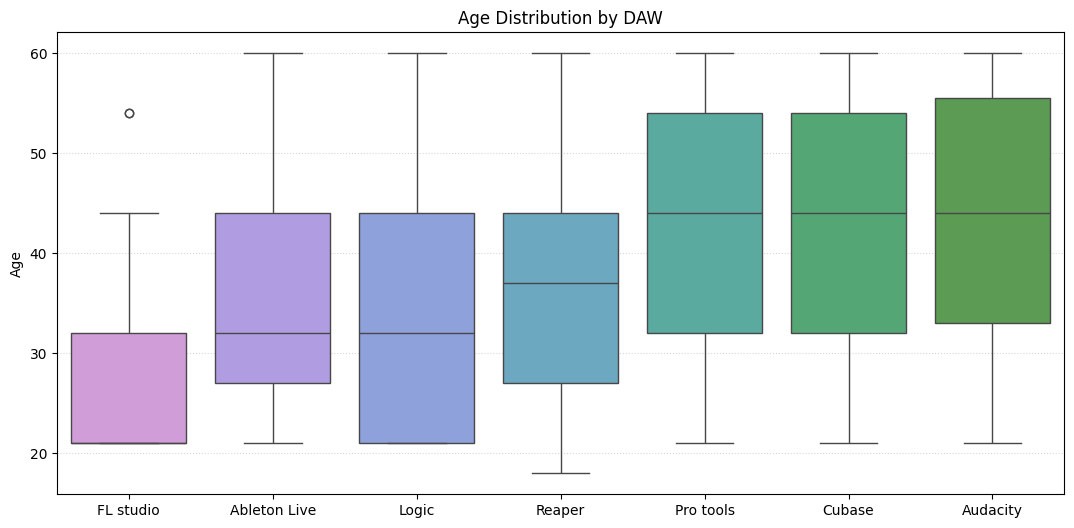

In [30]:
plt.figure(figsize=(13,6))
sb.boxplot(data = over_fifty_data_df,
            x="DAW",
            y="AdjustedAge",
            hue="DAW",
            palette=sb.cubehelix_palette(rot=2.5,
                                         n_colors=7,
                                         start=1.1,
                                         light=0.7,
                                         dark=0.5,
                                         hue=1,
                                         as_cmap=False),
            saturation=1)
plt.title("Age Distribution by DAW")
plt.xlabel("")     # Excluded to reduce clutter, DAW names are already shown
plt.ylabel("Age")
plt.grid(True, axis="y", linestyle=":", alpha=0.5)

# Show Figure
plt.show()

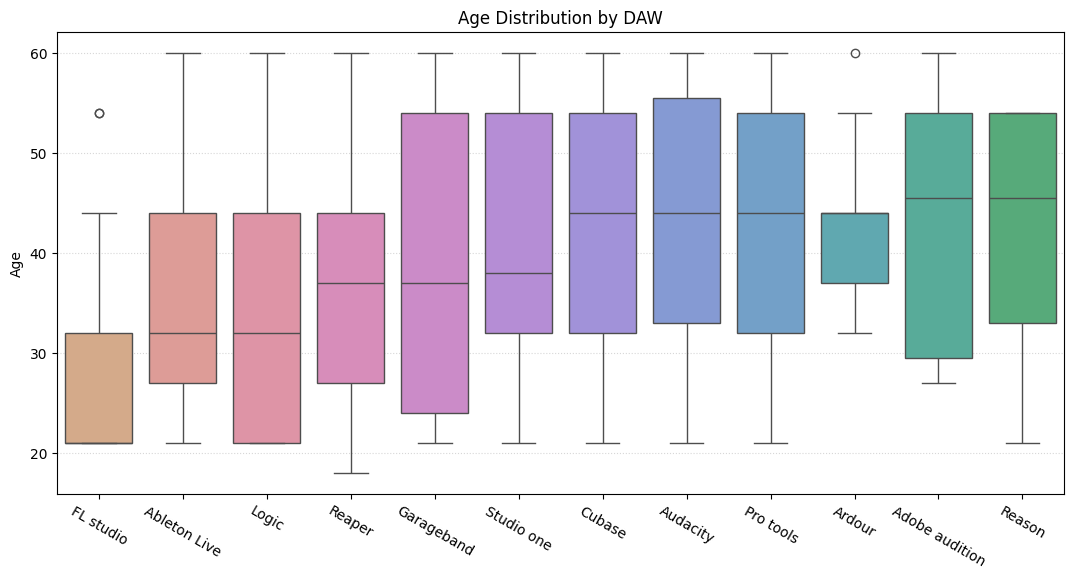

In [31]:
plt.figure(figsize=(13,6))
sb.boxplot(data = over_fifteen_data_df,
            x="DAW",
            y="AdjustedAge",
            hue="DAW",
            palette=sb.cubehelix_palette(rot=4.5,
                                         n_colors=12,
                                         start=0.7,
                                         light=0.7,
                                         dark=0.55,
                                         hue=1,
                                         as_cmap=False),
            saturation=1)
plt.title("Age Distribution by DAW")
plt.xlabel("")     # Excluded to reduce clutter, DAW names are already shown
plt.ylabel("Age")
plt.xticks(rotation=-30)
plt.grid(True, axis="y", linestyle=":", alpha=0.5)

# Show Figure
plt.show()

**<h1> Analysis of Age of Users (by DAW) </h1>**

Our data is a bit discrete by nature of the survey only asking for an age range rather than exact age. However, I think some observations can still be made.

<h4>Some Anecdotal Observations (and Opinions) From my own Personal Experience Using DAWs (~2007-Present):</h4>

 - **FL Studio**, **Logic**, and **Ableton Live** being the 3 youngest DAWs makes sense to me:
   - FL studio and Logic are the two "I've graduated from Garageband/Audacity and want something more powerful" DAWs, and are commonly recommended to beginners. I myself went from Garageband to Logic in middle school; it's a pretty common pipeline, or at least was at the time.
   - Ableton is less beginner friendly than the other two, but came onto the scene more recently than other DAWs like Cubase or Pro Tools, putting it somewhere in the middle. Ableton is EXTREMELY versitile and powerful, and is becoming an industry standard, but not yet "the" industry standard. I'll look a little bit more in this in a direct comparison section later on.
 - **Reaper** and **Garageband** surprise me that they aren't younger:
   - Reaper has the "new" factor, becoming popular quite recently (relatively speaking), and is much cheaper than most of the other DAWs on this list. When I get to the popularity over time portion of analysis, Reaper is one I'll be keeping a close eye on, I think it has a lot of potential to challenge the Logics, FL Studios and mayyybe even Abletons of the world.
   - Garageband stands out as being a) FREE and b) automatically installed on most Apple products (I think this is still a thing? I know it at least was for well over a decade), making it one of the most natural starting points for every beginner. It does have the widest distribution of any DAW represented, which tracks as it's the most accessible. Garageband surprised me on how few respondants it had, but I have a suspicion that the average Garageband user is far less likely to stuble across a survey about DAW usage compared to the average Pro Tools user.
 - **Cubase** and **Pro Tools** are the old guard:
    - Avid (the company behind Pro Tools) has its teeth firmly in the industry, and we see an older userbase because those using Pro Tools are likely already established in the field. However, Avid indulges in some... less than friendly ~~consumer profit extraction~~ business practices:
      - Changed from permanent ownership to subscription model, which is rare in the DAW world
      - Exclusive compatibility with other standard software, notably Dolby Atmos
      - Required hardware, specifically certain interfaces (although as far as I can see this has since been remedied)
      - iLok liscence manager means that you CANNOT USE THE SOFTWARE OFFLINE without a physical USB stick, which is much less common than authentication via the cloud. No option to authorize to a specific computer.
   - Avid is more or less the Adobe of the audio world, but Pro Tools and its peripherals are already integrated into so many studios that change is diffuclt. I know I sound like a hater here (and I admittedly am), but the software itself, when used as intended, is quite sufficient for most any purpose. I can't bring myself to call it "good," but I will freely admit that those holding onto it don't really have an incentive to change if money isn't an issue. From what I see online, these issues seem to be at least not getting worse since my brush with Pro Tools circa 2018, but then again Avid was acquired by the private equity firm STG in 2023, and private equity isn't often known for improving consumer experience.
    - Cubase is also old, being released in 1989, but has received continued support since then. Not nearly so much controversy around it, in fact Cubase paved the way for many now universal features, particularly the VST format allowing for 3rd party plug-ins to be used. I think Cubase struggles to accrue a younger demographic because it has this old-school reputation, and the UI was a bit outdated (read: completely and utterly overwhelming) during the early 2010s when electronic music exploded in popularity and DAWs became more accessible to your average person. I don't see Cubase going away any time soon, but I also don't see it rising in popularity any time soon.
 - **Adobe Audition** is fine, but a little underpowered.
   - Its main advantage is its connection to the wider Adobe suite, notably being able to link to Premier smoothly. This makes it a standout in multimedia situations, particularly producing/mixing/editing for film or video. As a standalone though, it has most basic functionality, but not much more than that. I'm not in the digital arts sphere enough to have a picture of the average Creative Cloud user, so I don't really have any expectation for this data to meet or not meet.
 - **Audacity** is the odd one out here, being completely unsuited for many of the functions you want a DAW for.
   - I know people who are more hardware musicians who try to record everything into Audacity and run into these limitations almost immediately. It cannot use virtual instruments, and there is no MIDI editor, parameter automation, or channel routing. Wikipedia goes so far as to say that it should be excluded from the category of DAW, and I can't entirely disagree. However, this survey looks specifically at use cases, and Audacity is perfectly fine for simple tasks involving simple recording and editing. Notably, Audacity is also free (and open source!) and its simplicity can be attractive for those just dipping their toes into the world of audio software. I wouldn't have expected the age to skew as old as it does, but I don't know that I had any particular expectation for it. I'm really curious to see the use cases for this one!
 - I have no experience with or predispositions towards **Studio One**, **Ardour**, or **Reason**. 

<h4> Observations and Analysis Unrelated to my own Experiences:</h4>

I'd like to compare this age range data to the population of each DAW to get an idea whether the overall usage is trending younger or older. First I'll get an average age over ALL respondants (personal_data_df) in this dataset, in order to get a baseline which includes users of DAWs outside of the threshold. Since I'm trying to get an idea of the age for the most popular DAWs, I'll restrict this to just those DAWs with over 50 users. Then I'll calculate the representation of each DAW within the threshold as a proportion of total responses, and weight the age value by this ratio. I'll do this by creating a new column to carry this weight value within the existing DataFrame.  

In [32]:
# Get the age distribution for selected DAWs
DAW_weights = over_fifty_data_df.value_counts(subset="DAW")
DAW_weights = DAW_weights.mul(1 / len(personal_data_df))

weighted_age = over_fifty_data_df["AdjustedAge"].copy()
for i in range(len(weighted_age)):
    weighted_age[i] = weighted_age[i] * DAW_weights[over_fifty_data_df.loc[i, "DAW"]]

if ("WeightedAge" in over_fifty_data_df.keys()):
    over_fifty_data_df.pop("WeightedAge")
over_fifty_data_df.insert(loc=len(over_fifty_data_df.columns), value=weighted_age, column="WeightedAge")

over_fifty_data_df.head()

,DAW,AverageAge,AdjustedAge,WeightedAge
0,FL studio,21.0,27.0,1.802932
471,FL studio,21.0,21.0,1.402280
469,FL studio,21.0,32.0,2.136808
168,FL studio,21.0,27.0,1.802932
466,FL studio,21.0,21.0,1.402280


In [33]:
# Get sums of all age ranges in full distribution
age_values = []
for i in range(len(personal_data_df)):
    # Create an entry if it does not exist
    if not personal_data_df.loc[i, "AdjustedAge"] in age_values:
        age_values.append(int(personal_data_df.loc[i, "AdjustedAge"]))

# Use this list as the indices of a Series, where 
# we can weight each age as we did for the threshold cases
age_distribution = pd.Series(index=age_values)
age_distribution.fillna(value=0, inplace=True)
for i in range(len(personal_data_df)):
    age_distribution[int(personal_data_df.loc[i, "AdjustedAge"])] += personal_data_df.loc[i, "AdjustedAge"]

# Normalize everything and convert to DataFrame
age_distribution = age_distribution.mul(1 / len(personal_data_df))
age_distribution_df = pd.DataFrame(data=age_distribution, columns=["WeightedAge"])
age_distribution_df = age_distribution_df.div(age_distribution.max())
age_distribution_df = age_distribution_df.mul(100)

age_distribution_df.head(10)

,WeightedAge
27,37.723547
21,51.248137
32,49.478390
37,43.423994
44,100.000000
54,89.530551
60,55.886736
18,0.335320


In [34]:
# Convert Adjusted Age to Int for use as axis labels later
over_fifty_data_df["AdjustedAge"] = over_fifty_data_df["AdjustedAge"].convert_dtypes()

# Group by DAW
ages_grouped_by_DAW = over_fifty_data_df.groupby(["DAW", "AdjustedAge"])
weighted_ages_grouped_by_DAW = ages_grouped_by_DAW.sum("WeightedAge")

# Not needed for this visualization
weighted_ages_grouped_by_DAW = weighted_ages_grouped_by_DAW.drop(columns="AverageAge")

# Also normalize the weights for each DAW so that our graphs are consistent in scale
for D in over_fifty_uses_df.keys():
    m = weighted_ages_grouped_by_DAW["WeightedAge"].loc[D].max()
    weighted_ages_grouped_by_DAW.loc[D, "WeightedAge"] = weighted_ages_grouped_by_DAW["WeightedAge"].div(m)
    weighted_ages_grouped_by_DAW.loc[D, "WeightedAge"] = weighted_ages_grouped_by_DAW["WeightedAge"].mul(100)

<H2> Numeric Data for All Users and By DAW</H2>

In [35]:
for D in over_fifty_uses_df.keys():
    print("\n=====",D,"=====",sep="")
    print(weighted_ages_grouped_by_DAW.loc[D, "WeightedAge"].describe())


=====Audacity=====
count      5.000000
mean      56.833333
std       29.275986
min       30.833333
25%       35.000000
50%       45.000000
75%       73.333333
max      100.000000
Name: WeightedAge, dtype: float64

=====Cubase=====
count      7.000000
mean      40.183150
std       28.512492
min       13.846154
25%       23.974359
50%       32.820513
75%       43.333333
max      100.000000
Name: WeightedAge, dtype: float64

=====FL studio=====
count      6.000000
mean      38.681850
std       32.069429
min        7.660455
25%       23.395445
50%       31.469979
75%       38.457557
max      100.000000
Name: WeightedAge, dtype: float64

=====Logic=====
count      7.000000
mean      56.919643
std       33.553281
min       10.511364
25%       38.565341
50%       45.454545
75%       82.670455
max      100.000000
Name: WeightedAge, dtype: float64

=====Ableton Live=====
count      7.000000
mean      61.753247
std       22.057445
min       36.363636
25%       49.772727
50%       50.909091
75% 

While this gives us a sneak peek, the real focus will be the visualization! I'll do this using by a plot with an x axis of age and a y axis of the proportion of the x value of age to the highest weighted age in that subset. This will be highlighted in front of the distribution of the age ranges of all respondants. Basically, for each age, do we see more or fewer users than we expect based on the overall userbase?

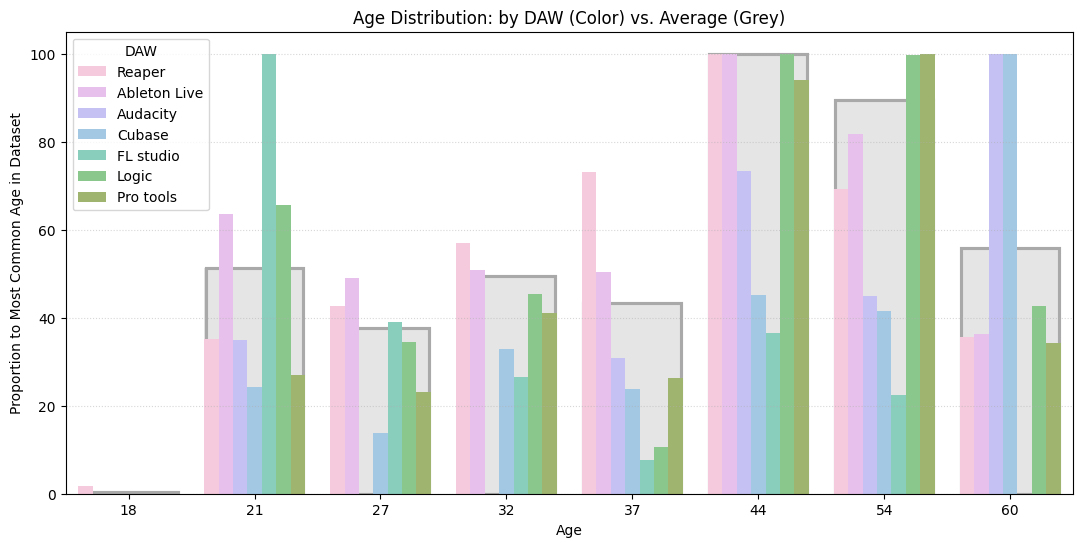

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(13,6))

# Overall Distribution (Transparent)
sb.barplot(ax=ax,
            data=age_distribution_df,
            x=age_distribution.index,
            y="WeightedAge",
            color="darkgrey",
            dodge=True,
            alpha=0.3
            )

# Overall Distribution (Outline)
sb.barplot(ax=ax,
            data=age_distribution_df,
            x=age_distribution.index,
            y="WeightedAge",
            color="darkgrey",
            dodge=True,
            alpha=1,
            fill=False,
            width=0.777
            )

# Distribution by DAW
sb.barplot(ax=ax,
            data=weighted_ages_grouped_by_DAW,
            x="AdjustedAge",
            y="WeightedAge",
            hue="DAW",
            palette=sb.cubehelix_palette(rot=3.5,
                                         n_colors=7,
                                         start=0.77,
                                         light=0.85,
                                         dark=0.65,
                                         hue=1,
                                         as_cmap=False),
            saturation=1.0,
            alpha=1.0,
            dodge=True
            )

plt.title("Age Distribution: by DAW (Color) vs. Average (Grey)")
plt.xlabel("Age") 
plt.ylabel("Proportion to Most Common Age in Dataset")
plt.grid(True, axis="y", linestyle=":", alpha=0.5)

# Show Figure
plt.show()

**<h4>Comparison to Earlier Analysis:</h4>**

 - **Reaper:** While this does have disproportionate representation in the late 20's - late 30's band, it peaks in the 40's with the average distribution. As the newest DAW on this list I am a bit surprised at how quickly it's been adopted by all age groups, but I think that speaks to the value of a low price point in a market dominated by bewilderingly expensive software.
 - **Ableton:** As the most popular DAW in this dataset, it's not too surprising to see it relatively in line with the average. The most disproportionate cases are higher use in the early 20's and lower use in the 60+ category, which also tracks with expectations. The versatility and power of Ableton, combined with the fact that it has a generous student plan, make it good for education, which I suspect but cannot prove based on this analysis. Looking at the use cases and training may give us insight if it correlates strongly with the "Teaching" context or higher rates of "Yes" responses in training.
 - **Audacity:** This one is tricky. We see a below average populations in early 20's and late 30's - 50's, and no representation at all (!) for late 20's - early 30's. We also see an incredible over-representation in the 60+ range. I genuinely don't know what to make of this without running analysis of use cases; I am flummoxed.
 - **Cubase:** We see an underrepresentation for all groups except 60+, which tracks quite well with what I expected, perhaps even more strongly than I would've guessed.
 - **FL Studio:** Again this tracks with what I expected, but even more strongly. FL Studio is far and away most represented by those in their early 20's, and completely disappears by the time we hit the 60's. In the early 2010's maybe I could understand this, but this survery was in 2023! My guess would be that FL acts as a starter DAW: easy to pick up, comes up easily in Google results, and lacks either power or applicability to desired use case, driving users away over time. 
 - **Logic:** Logic seems to be the most well-distributed DAW here, only falling significantly short in the late 30's age range. Logic was released in the 1993 (32 years ago, hmmm...), but aquired by Apple in 2002, so I wonder if there is a divide between those who grew up with Logic as one of the most accessible DAWs (the younger group represented here, including myself), and the group that was just getting into music production when Logic was still relatively unknown. My guesses as to the representation on older groups are either the proliferation of Apple computers and the fact that Apple really doesn't like to play well with certain DAWs, or that older users may have already been comfortable with multiple DAWs and simply added Logic to their arsenal once it released. This last section is more or less conjecture though, as I don't have data on OS vs. age, and number of DAWs used vs. Age may end up sidelined compared to other analyses.
 - **Pro Tools:** Underrepresented in all groups except the peak ages for DAW use. This one also isn't too surprising. I would guess that there is a very strong correlation between "Professional" level and Pro Tools users, at least compared to other DAWs, and a very low correlation between "Amateur" level and Pro Tools users, which can be verified during Use Case analysis. 

**<h1>Use Cases by DAW</h1>**
I'm planning to use the Use Cases dataframe to make a heatmap of use cases by DAW. Some questions lingered from the previous analysis that I'm hoping will be tackled here. 

 - Does **Ableton** show higher than average rates of the "Teaching" context and/or the "Yes" training response?
 - Does **Pro Tools** show higher than average rates of the "Professional" and/or "Semi-Professional" level response?
 - Why do people use **Audacity** ("Task" responses)? Might there be any link to the unusual age distribution?
 - Is there a significant discrepency in Use Case data between the older and younger groups of **Logic** users?

Preview of the current Dataframe and a close-up at one element:

In [37]:
use_cases_by_daw_df.head()

,Unspecified,Acid pro,Biab,Ardour,Reason,Audacity,Other,Pyramix,Digital performer,Cubase,...,Nuendo,Mainstage,Cakewalk,Soundbooth,Goldwave,Pro tools,Non daw studio,Mixbus,Samplitude,Renoise
0,NaN,NaN,NaN,NaN,NaN,"{'OS': 'Windows', 'Start': '2012', 'End': '202...",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"{'OS': 'Windows', 'Start': '2018', 'End': '201...",NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"{'OS': 'Mac', 'Start': '2014', 'End': '2023', ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
print(use_cases_by_daw_df.loc[0, "Audacity"])

{'OS': 'Windows', 'Start': '2012', 'End': '2023', 'Task': ['Editing', 'Post-production', 'Scientific research or measurements'], 'Context': ['Music (Electronic)', 'Sampling', 'Speech recording'], 'Level': 'Semi-professional'}


I need to decide which items from the Use Cases DataFrame to include in this visualization. Many will be irrelevant or cause clutter, so I'll create a trimmed down Dataframe to use here.

I'm cutting out:
- All DAWs below the 50 user threshold
- OS
- Start and End dates

Both the "Task" and "Context" sections may contain up to 13 or 11 items each, which may be too much information to view at once. Because of this, I will create two heatmaps: one for each section. Towards this end, I will create two DataFrames, one with axes for "DAW" and "Task", and the other with axes for "DAW" and "Context". 

The "Level" information will be set aside for a third DataFrame, as including it with either of the above dataframes would seem non-homogeneous. 

**<h4>Tasks Heatmap</h4>**

I'll create an empty DataFrame with labelled rows and columns as mentioned above, and iterate over the Use Case DataFrame, incrementing the corresponding entry on the task DataFrame. Certain entries don't line up with the options listed in the readme, so I've adjusted the labels to fit the actual data.

In [45]:
print(type(use_cases_by_daw_df.loc[0, "Audacity"]["Task"]))

<class 'list'>


In [56]:
tasks = ["Draft",
        "Tracking",
        "Editing",
        "Sequencing and Programming",
        "Mixing",
        "Mastering",
        "Post-production",
        "Live performance",
        "Live sound engineering",
        "Restoration",
        "Teaching",
        "Scientific research or measurements",
        "Other"]
tasks_df = pd.DataFrame(0, index=over_fifty_uses_df.keys(), columns=tasks)

# Iterate by DAW
for d in over_fifty_uses_df.keys():

    # Get each entry for the corresponding DAW
    for e in use_cases_by_daw_df[d].dropna():

        # Get each task from the entry
        for t in e["Task"]:

            # Catch tasks that aren't in keys. Adjusted as per text above.
            if not t in tasks:
                print("Invalid Task: ", t)

            # Increment
            else:
                tasks_df.loc[d, t] += 1
    

tasks_df

,Draft,Tracking,Editing,Sequencing and Programming,Mixing,Mastering,Post-production,Live performance,Live sound engineering,Restoration,Teaching,Scientific research or measurements,Other
Audacity,16,22,34,6,16,10,16,4,3,6,12,19,8
Cubase,42,61,76,68,74,52,33,14,11,7,12,9,4
FL studio,37,34,45,47,52,38,24,5,6,11,7,5,7
Logic,66,86,100,77,101,75,58,24,8,12,28,20,10
Ableton Live,137,131,165,182,154,93,86,135,43,24,56,34,18
Reaper,73,112,129,68,130,91,77,45,26,28,47,31,9
Pro tools,35,92,111,36,114,76,80,15,21,34,30,13,5


Once again, we want to adjust each value to the percentage of the max value for that DAW, so that each DAW has the same highest value. This will help examine the prevalence of each task relative to the other tasks in that DAW, rather than to the most popular task overall: Sequencing and Programming in Ableton Live. 

In order to easily transform uniformly by DAW rather than by task, I'll also transpose the DataFrame before normalization.

In [82]:
tasks_df = tasks_df.transpose()

# Each column
for d in tasks_df.keys():

    max_val = tasks_df[d].max()
    tasks_df[d] = tasks_df[d].div(max_val)
    tasks_df[d] = tasks_df[d].mul(100)

tasks_df.describe()

,Draft,Tracking,Editing,Sequencing and Programming,Mixing,Mastering,Post-production,Live performance,Live sound engineering,Restoration,Teaching,Scientific research or measurements,Other
count,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000
mean,76.093211,88.601598,96.115270,65.375660,89.863233,83.288012,75.467678,35.728357,63.369796,59.606890,73.300547,38.620115,44.536509
std,20.275083,10.411088,5.343536,31.921776,19.693914,21.857349,13.771092,30.603451,25.137480,23.705997,24.610430,28.621233,27.807709
min,40.786272,75.105042,86.538462,17.647059,47.058824,39.607843,61.875000,12.962963,33.525213,30.882353,37.234043,17.206478,18.640351
25%,67.965696,79.719388,94.013881,41.943320,90.991903,79.295482,66.414027,16.799679,43.091655,42.025767,58.230683,20.798707,25.895749
50%,74.598540,93.162594,99.009901,76.237624,100.000000,92.140351,67.335165,24.834308,61.260710,59.169550,76.680008,33.429728,42.032967
75%,90.668136,96.252388,99.615385,89.929150,100.000000,96.338462,83.117765,39.350935,81.309670,71.572398,91.364205,39.053594,49.645373
max,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000


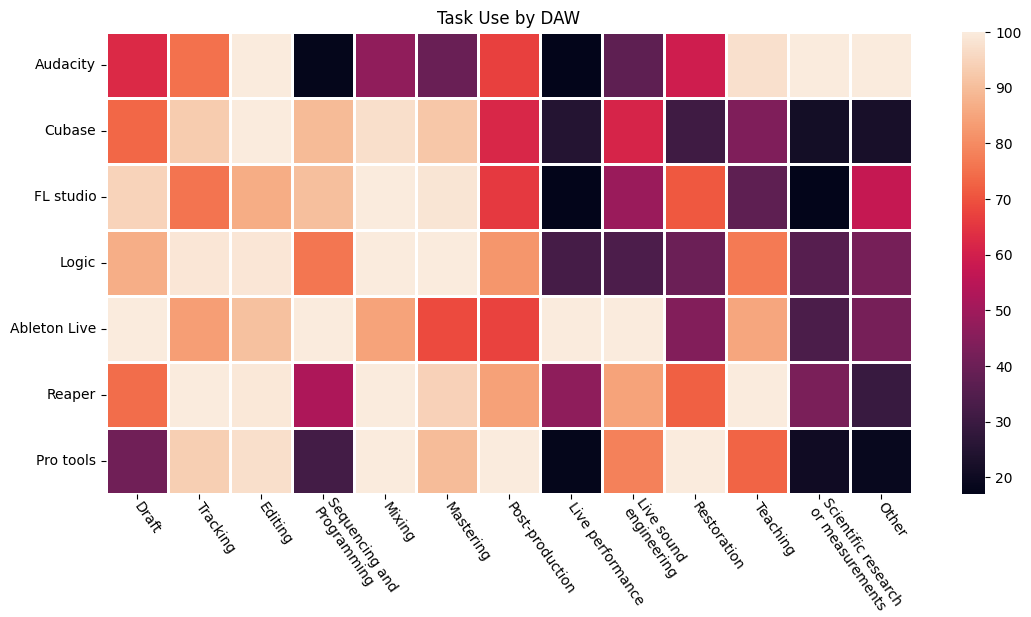

In [112]:
plt.figure(figsize=(13,6))
sb.heatmap(data=tasks_df,
          robust=True,
          linewidth=0.75,
          linecolor="White",
          cmap="rocket"
          ) # FIXME find better cmap

plt.title("Task Use by DAW")
plt.xlabel("")     # Excluded to reduce clutter
plt.ylabel("")     # Excluded to reduce clutter
plt.xticks(rotation=-55, ha="left", va="center", wrap=True)

# Show Figure
plt.show()